In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import argparse
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from mmwhs_dataloader import MMWHS_single
from models.crosscompcsd import CrossCSD, CrossCSDFirst
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import KFold
import pytorch_lightning as pl
import glob
import numpy as np
import matplotlib.pyplot as plt

from eval import eval_vmfnet_mm
from utils import *
import random

2024-05-14 12:52:39.784565: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 12:52:39.862315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 12:52:39.862489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 12:52:39.864334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 12:52:39.877377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [2]:
class ARGS():
    def __init__(self) -> None:
        self.pretrain = False
        self.weight_init = "xavier"
        self.init = "xavier"
        self.vc_num_seg = 10
        self.norm = "Batch"
        self.layer = 8
        self.vc_num  = 10
        self.true_clu_loss = True
        self.encoder_type = "unet"
        self.learning_rate = 0.0001
        self.k2 = 10
        self.k_folds = 5
        self.cp = 'checkpoints/'
        self.content_disc = False

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = ARGS()
fold = 3
fold_test = [4, 9, 12, 19]
print(fold_test)

[4, 9, 12, 19]


In [43]:
def visualize(com_features, img, label, compact_pred_t):
    # plot the img, label, compact_pred_t and the ten items from com_features in one image with plt
    fig, axs = plt.subplots(1, 13, figsize=(18, 8))
    axs[0].imshow(img[0, 0, :, :], cmap="gray")
    axs[0].set_title('img')
    axs[0].axis('off')
    axs[1].imshow(label[0, 0, :, :], cmap="gray")
    axs[1].set_title('label')
    axs[1].axis('off')
    axs[2].imshow(compact_pred_t[0, 0, :, :], cmap="gray")
    axs[2].set_title('pred')
    axs[2].axis('off')
    for i in range(10):
        axs[i+3].imshow(com_features[0, i, :, :], cmap="gray")
        axs[i+3].set_title(r'$Z_{vMF}$' + f'({i+1})')
        axs[i+3].axis('off')

In [32]:
def test_type(save_dir, fold_test, labels):

    data_dir = '../data/other/CT_withGT_proc/'
    print("loading test data")
    dataset_test = MMWHS_single(data_dir, fold_test, labels) 
    test_loader = DataLoader(dataset_test, batch_size=1, num_workers=4)


    pretrained_model = glob.glob(os.path.join(save_dir, "*.pth"))

    if pretrained_model == []:
        print("no pretrained model found!")
        quit()
    else:
        model_file = pretrained_model[0]

    print("Loading model: ", model_file)
    model = CrossCSD(args, device, 1, 2, vMF_kappa=30, fold_nr=fold)
    model.to(device)
    model.resume(model_file, cpu=True)
    model.eval()

    for it, (img, label) in enumerate(test_loader):
        if it == 20:
            img = img.to(device)
            label = label.to(device)

            with torch.no_grad():
                com_features, compact_pred_t  = model.forward_test(img)
        
            return com_features, img, label, compact_pred_t
    

In [33]:
dir_checkpoint = 'checkpoints/proposed/xavier_init_true_opt_10_all'
save_dir = os.path.join(dir_checkpoint, f'fold_{fold}')
labels = [1, 0, 0, 0, 0]
com_features, img, label, compact_pred_t = test_type(save_dir, fold_test, labels)


loading test data
Loading model:  checkpoints/proposed/xavier_init_true_opt_10_all/fold_3/CP_epoch_100_DSC_T_fake_0.8104743361473083.pth


RESULTS MYO PROPOSED 10


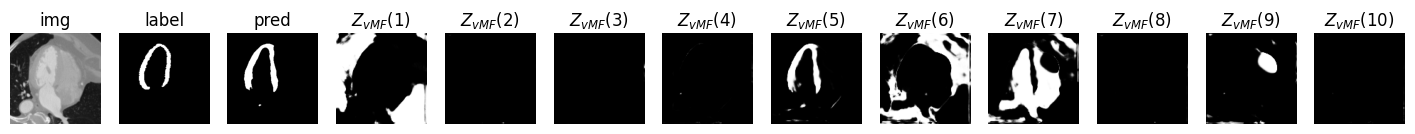

In [34]:
print("RESULTS MYO PROPOSED 10")
visualize(com_features, img, label, compact_pred_t)

In [35]:
dir_checkpoint = 'checkpoints/proposed_LV/xavier_init_true_opt_10_all'
save_dir = os.path.join(dir_checkpoint, f'fold_{fold}')
labels = [0, 0, 1, 0, 0]
com_features, img, label, compact_pred_t = test_type(save_dir, fold_test, labels)

loading test data
Loading model:  checkpoints/proposed_LV/xavier_init_true_opt_10_all/fold_3/CP_epoch_125_DSC_T_fake_0.9160342216491699.pth


RESULTS LV PROPOSED 10


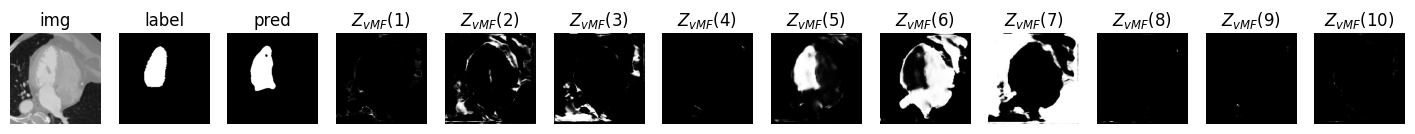

In [36]:
print("RESULTS LV PROPOSED 10")
visualize(com_features, img, label, compact_pred_t)

In [37]:
dir_checkpoint = 'checkpoints/proposed_RV/xavier_init_true_opt_10_all'
save_dir = os.path.join(dir_checkpoint, f'fold_{fold}')
labels = [0, 0, 0, 0, 1]
com_features, img, label, compact_pred_t = test_type(save_dir, fold_test, labels)

loading test data
Loading model:  checkpoints/proposed_RV/xavier_init_true_opt_10_all/fold_3/CP_epoch_85_DSC_T_fake_0.8675152063369751.pth


RESULTS RV PROPOSED 10


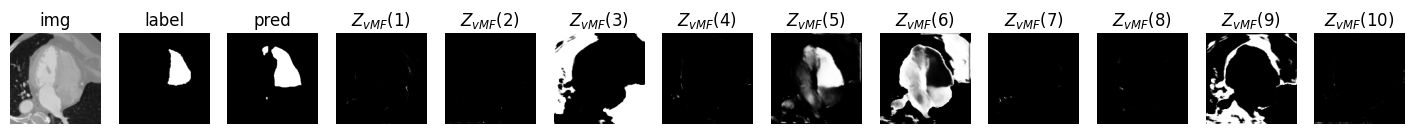

In [44]:
print("RESULTS RV PROPOSED 10")
visualize(com_features, img, label, compact_pred_t)